In [1]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

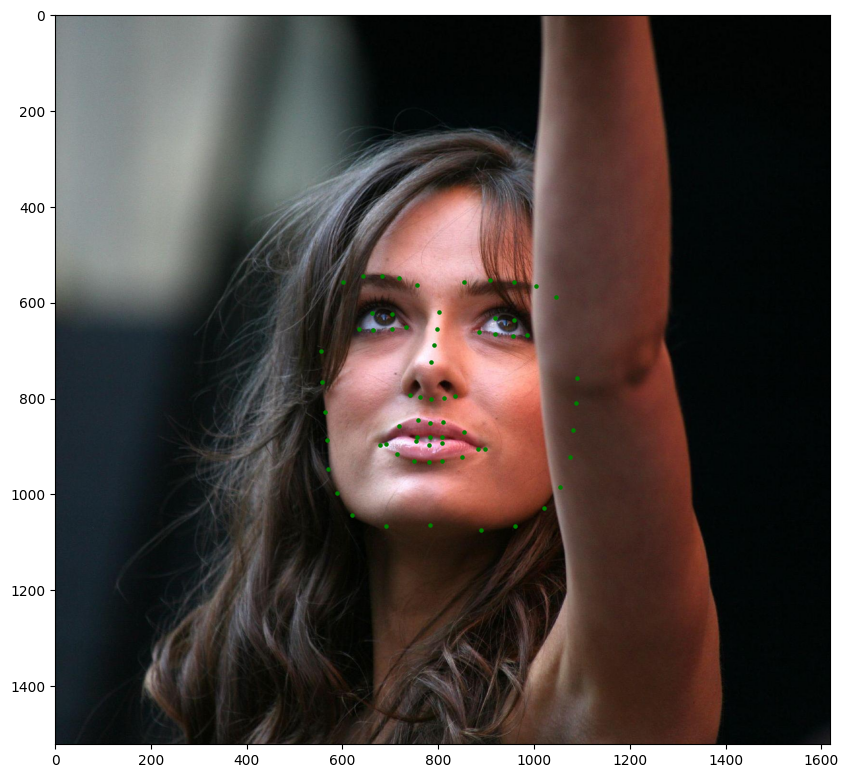

In [3]:
file = open('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

In [4]:
class Transforms():
    def __init__(self):
        pass

    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))],
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3,
                                              contrast=0.3,
                                              saturation=0.3,
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)

        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [5]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'

        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]

        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


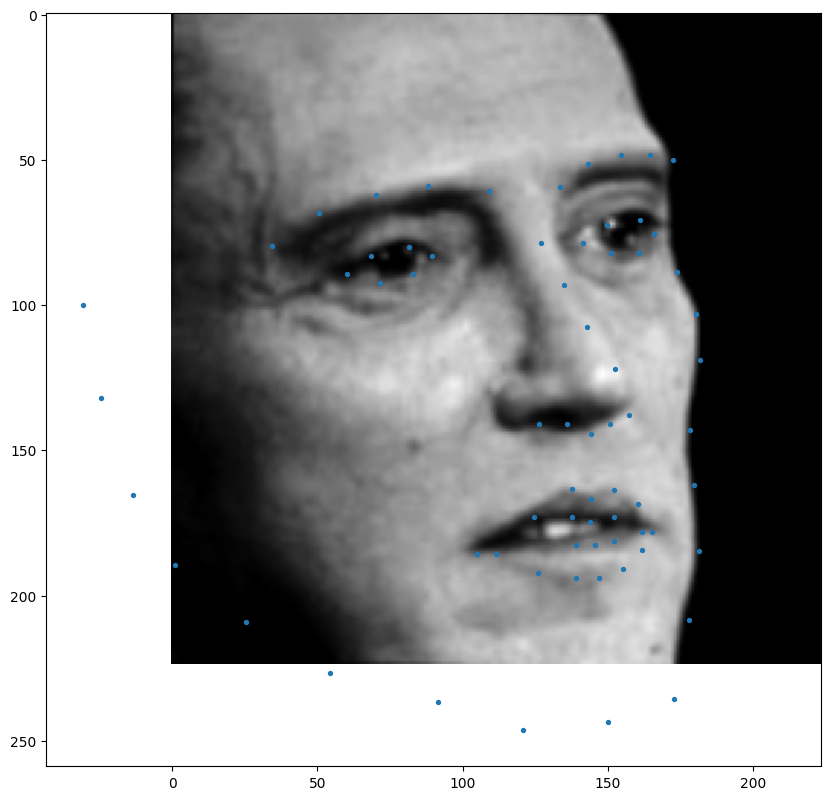

In [6]:
image, landmarks = dataset[0]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

In [7]:
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 6000
The length of Valid set is 666


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])


In [9]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x

In [10]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))

    sys.stdout.flush()

In [11]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 10

start_time = time.time()
for epoch in range(1,num_epochs+1):

    loss_train = 0
    loss_valid = 0
    running_loss = 0

    network.train()
    for step in range(1,len(train_loader)+1):

        images, landmarks = next(iter(train_loader))

        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda()

        predictions = network(images)

        # clear all the gradients before calculating them
        optimizer.zero_grad()

        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)

        # calculate the gradients
        loss_train_step.backward()

        # update the parameters
        optimizer.step()

        loss_train += loss_train_step.item()
        running_loss = loss_train/step

        print_overwrite(step, len(train_loader), running_loss, 'train')

    network.eval()
    with torch.no_grad():

        for step in range(1,len(valid_loader)+1):

            images, landmarks = next(iter(valid_loader))

            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()

            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')

    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)

    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth')
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 1/94  Loss: 0.3642 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 2/94  Loss: 0.3245 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 3/94  Loss: 0.2923 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 4/94  Loss: 0.2658 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 5/94  Loss: 0.2411 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 6/94  Loss: 0.2198 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 7/94  Loss: 0.2012 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 8/94  Loss: 0.1860 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 9/94  Loss: 0.1720 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 10/94  Loss: 0.1599 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 11/94  Loss: 0.1494 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 12/94  Loss: 0.1400 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 13/94  Loss: 0.1316 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 14/94  Loss: 0.1241 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 15/94  Loss: 0.1173 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 16/94  Loss: 0.1113 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 17/94  Loss: 0.1057 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 18/94  Loss: 0.1008 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 19/94  Loss: 0.0963 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 20/94  Loss: 0.0921 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 21/94  Loss: 0.0883 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 22/94  Loss: 0.0849 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 23/94  Loss: 0.0816 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 24/94  Loss: 0.0787 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 25/94  Loss: 0.0759 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 26/94  Loss: 0.0734 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 27/94  Loss: 0.0710 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 28/94  Loss: 0.0689 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 29/94  Loss: 0.0668 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 30/94  Loss: 0.0649 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 31/94  Loss: 0.0631 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 32/94  Loss: 0.0613 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 33/94  Loss: 0.0597 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 34/94  Loss: 0.0582 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 35/94  Loss: 0.0568 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 36/94  Loss: 0.0554 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 37/94  Loss: 0.0542 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 38/94  Loss: 0.0530 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 39/94  Loss: 0.0518 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 40/94  Loss: 0.0507 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 41/94  Loss: 0.0497 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 42/94  Loss: 0.0487 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 43/94  Loss: 0.0477 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 44/94  Loss: 0.0468 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 45/94  Loss: 0.0460 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 46/94  Loss: 0.0451 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 47/94  Loss: 0.0443 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 48/94  Loss: 0.0436 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 49/94  Loss: 0.0428 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 50/94  Loss: 0.0422 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 51/94  Loss: 0.0415 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 52/94  Loss: 0.0408 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 53/94  Loss: 0.0402 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 54/94  Loss: 0.0396 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 55/94  Loss: 0.0390 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 56/94  Loss: 0.0384 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 57/94  Loss: 0.0379 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 58/94  Loss: 0.0373 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 59/94  Loss: 0.0368 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 60/94  Loss: 0.0363 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 61/94  Loss: 0.0358 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 62/94  Loss: 0.0354 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 63/94  Loss: 0.0349 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 64/94  Loss: 0.0345 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 65/94  Loss: 0.0341 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 66/94  Loss: 0.0336 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 67/94  Loss: 0.0333 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 68/94  Loss: 0.0329 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 69/94  Loss: 0.0325 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 70/94  Loss: 0.0321 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 71/94  Loss: 0.0317 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 72/94  Loss: 0.0314 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 73/94  Loss: 0.0311 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 74/94  Loss: 0.0307 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 75/94  Loss: 0.0304 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 76/94  Loss: 0.0301 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 77/94  Loss: 0.0298 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 78/94  Loss: 0.0295 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 79/94  Loss: 0.0292 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 80/94  Loss: 0.0289 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 81/94  Loss: 0.0286 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 82/94  Loss: 0.0284 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 83/94  Loss: 0.0281 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 84/94  Loss: 0.0278 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 85/94  Loss: 0.0276 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 86/94  Loss: 0.0273 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 87/94  Loss: 0.0271 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 88/94  Loss: 0.0268 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 89/94  Loss: 0.0266 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 90/94  Loss: 0.0264 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 91/94  Loss: 0.0262 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 92/94  Loss: 0.0259 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 93/94  Loss: 0.0257 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 94/94  Loss: 0.0255 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 1/84  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 2/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 3/84  Loss: 0.0048 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 4/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 5/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 6/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 7/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 8/84  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 9/84  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 10/84  Loss: 0.0057 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 11/84  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 12/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 13/84  Loss: 0.0057 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 14/84  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 15/84  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 16/84  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 17/84  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 18/84  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 19/84  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 20/84  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 21/84  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 22/84  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 23/84  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 24/84  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 25/84  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 26/84  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 27/84  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 28/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 29/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 30/84  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 31/84  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 32/84  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 33/84  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 34/84  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 35/84  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 36/84  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 37/84  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 38/84  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 39/84  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 40/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 41/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 42/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 43/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 44/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 45/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 46/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 47/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 48/84  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 49/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 50/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 51/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 52/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 53/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 54/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 55/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 56/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 57/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 58/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 59/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 60/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 61/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 62/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 63/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 64/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 65/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 66/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 67/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 68/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 69/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 70/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 71/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 72/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 73/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 74/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 75/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 76/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 77/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 78/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 79/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 80/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 81/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 82/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 83/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 84/84  Loss: 0.0064 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0255  Valid Loss: 0.0064
--------------------------------------------------

Minimum Validation Loss of 0.0064 at epoch 1/10
Model Saved



/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 1/94  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 2/94  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 3/94  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 4/94  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 5/94  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 6/94  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 7/94  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 8/94  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 9/94  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 10/94  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 11/94  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 12/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 13/94  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 14/94  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 15/94  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 16/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 17/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 18/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 19/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 20/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 21/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 22/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 23/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 24/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 25/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 26/94  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 27/94  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 28/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 29/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 30/94  Loss: 0.0062 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 31/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 32/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 33/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 34/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 35/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 36/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 37/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 38/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 39/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 40/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 41/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 42/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 43/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 44/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 45/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 46/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 47/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 48/94  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 49/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 50/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 51/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 52/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 53/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 54/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 55/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 56/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 57/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 58/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 59/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 60/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 61/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 62/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 63/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 64/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 65/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 66/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 67/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 68/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 69/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 70/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 71/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 72/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 73/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 74/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 75/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 76/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 77/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 78/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 79/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 80/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 81/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 82/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 83/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 84/94  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 85/94  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 86/94  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 87/94  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 88/94  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 89/94  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 90/94  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 91/94  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 92/94  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 93/94  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 94/94  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 1/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 2/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 3/84  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 4/84  Loss: 0.0057 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 5/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 6/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 7/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 8/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 9/84  Loss: 0.0064 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 10/84  Loss: 0.0065 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 11/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 12/84  Loss: 0.0063 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 13/84  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 14/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 15/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 16/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 17/84  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 18/84  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 19/84  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 20/84  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 21/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 22/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 23/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 24/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 25/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 26/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 27/84  Loss: 0.0057 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 28/84  Loss: 0.0057 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 29/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 30/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 31/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 32/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 33/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 34/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 35/84  Loss: 0.0061 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 36/84  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 37/84  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 38/84  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 39/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 40/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 41/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 42/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 43/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 44/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 45/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 46/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 47/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 48/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 49/84  Loss: 0.0060 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 50/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 51/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 52/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 53/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 54/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 55/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 56/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 57/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 58/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 59/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 60/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 61/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 62/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 63/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 64/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 65/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 66/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 67/84  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 68/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 69/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 70/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 71/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 72/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 73/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 74/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 75/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 76/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 77/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 78/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 79/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 80/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 81/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 82/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 83/84  Loss: 0.0059 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 84/84  Loss: 0.0058 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0059  Valid Loss: 0.0058
--------------------------------------------------

Minimum Validation Loss of 0.0058 at epoch 2/10
Model Saved



/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 1/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 2/94  Loss: 0.0058 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 3/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 4/94  Loss: 0.0057 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 5/94  Loss: 0.0057 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 6/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 7/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 8/94  Loss: 0.0054 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 9/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 10/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 11/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 12/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 13/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 14/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 15/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 16/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 17/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 18/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 19/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 20/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 21/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 22/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 23/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 24/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 25/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 26/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 27/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 28/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 29/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 30/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 31/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 32/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 33/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 34/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 35/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 36/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 37/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 38/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 39/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 40/94  Loss: 0.0056 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 41/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 42/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 43/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 44/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 45/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 46/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 47/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 48/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 49/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 50/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 51/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 52/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 53/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 54/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 55/94  Loss: 0.0055 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 56/94  Loss: 0.0054 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 57/94  Loss: 0.0054 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 58/94  Loss: 0.0054 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 59/94  Loss: 0.0054 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 60/94  Loss: 0.0054 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 61/94  Loss: 0.0054 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 62/94  Loss: 0.0054 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 63/94  Loss: 0.0054 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 64/94  Loss: 0.0054 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 65/94  Loss: 0.0054 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 66/94  Loss: 0.0054 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 67/94  Loss: 0.0054 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 68/94  Loss: 0.0054 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 69/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 70/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 71/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 72/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 73/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 74/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 75/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 76/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 77/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 78/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 79/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 80/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 81/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 82/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 83/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 84/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 85/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 86/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 87/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 88/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 89/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 90/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 91/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 92/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 93/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 94/94  Loss: 0.0053 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 1/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 2/84  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 3/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 4/84  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 5/84  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 6/84  Loss: 0.0048 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 7/84  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 8/84  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 9/84  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 10/84  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 11/84  Loss: 0.0048 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 12/84  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 13/84  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 14/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 15/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 16/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 17/84  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 18/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 19/84  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 20/84  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 21/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 22/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 23/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 24/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 25/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 26/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 27/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 28/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 29/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 30/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 31/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 32/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 33/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 34/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 35/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 36/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 37/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 38/84  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 39/84  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 40/84  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 41/84  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 42/84  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 43/84  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 44/84  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 45/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 46/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 47/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 48/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 49/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 50/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 51/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 52/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 53/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 54/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 55/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 56/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 57/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 58/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 59/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 60/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 61/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 62/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 63/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 64/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 65/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 66/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 67/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 68/84  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 69/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 70/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 71/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 72/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 73/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 74/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 75/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 76/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 77/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 78/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 79/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 80/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 81/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 82/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 83/84  Loss: 0.0050 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 84/84  Loss: 0.0050 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0053  Valid Loss: 0.0050
--------------------------------------------------

Minimum Validation Loss of 0.0050 at epoch 3/10
Model Saved



/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 1/94  Loss: 0.0052 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 2/94  Loss: 0.0051 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 3/94  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 4/94  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 5/94  Loss: 0.0048 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 6/94  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 7/94  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 8/94  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 9/94  Loss: 0.0049 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 10/94  Loss: 0.0048 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 11/94  Loss: 0.0048 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 12/94  Loss: 0.0048 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 13/94  Loss: 0.0048 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 14/94  Loss: 0.0048 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 15/94  Loss: 0.0048 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 16/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 17/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 18/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 19/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 20/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 21/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 22/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 23/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 24/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 25/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 26/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 27/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 28/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 29/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 30/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 31/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 32/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 33/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 34/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 35/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 36/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 37/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 38/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 39/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 40/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 41/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 42/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 43/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 44/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 45/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 46/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 47/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 48/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 49/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 50/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 51/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 52/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 53/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 54/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 55/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 56/94  Loss: 0.0047 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 57/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 58/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 59/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 60/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 61/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 62/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 63/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 64/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 65/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 66/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 67/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 68/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 69/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 70/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 71/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 72/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 73/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 74/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 75/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 76/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 77/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 78/94  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 79/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 80/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 81/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 82/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 83/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 84/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 85/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 86/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 87/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 88/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 89/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 90/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 91/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 92/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 93/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 94/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 1/84  Loss: 0.0046 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 2/84  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 3/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 4/84  Loss: 0.0032 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 5/84  Loss: 0.0034 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 6/84  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 7/84  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 8/84  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 9/84  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 10/84  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 11/84  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 12/84  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 13/84  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 14/84  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 15/84  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 16/84  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 17/84  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 18/84  Loss: 0.0039 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 19/84  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 20/84  Loss: 0.0041 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 21/84  Loss: 0.0041 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 22/84  Loss: 0.0041 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 23/84  Loss: 0.0042 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 24/84  Loss: 0.0042 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 25/84  Loss: 0.0042 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 26/84  Loss: 0.0042 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 27/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 28/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 29/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 30/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 31/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 32/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 33/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 34/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 35/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 36/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 37/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 38/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 39/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 40/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 41/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 42/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 43/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 44/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 45/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 46/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 47/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 48/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 49/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 50/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 51/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 52/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 53/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 54/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 55/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 56/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 57/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 58/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 59/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 60/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 61/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 62/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 63/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 64/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 65/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 66/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 67/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 68/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 69/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 70/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 71/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 72/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 73/84  Loss: 0.0044 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 74/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 75/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 76/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 77/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 78/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 79/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 80/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 81/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 82/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 83/84  Loss: 0.0043 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 84/84  Loss: 0.0043 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0045  Valid Loss: 0.0043
--------------------------------------------------

Minimum Validation Loss of 0.0043 at epoch 4/10
Model Saved



/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 1/94  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 2/94  Loss: 0.0045 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 3/94  Loss: 0.0042 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 4/94  Loss: 0.0041 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 5/94  Loss: 0.0041 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 6/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 7/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 8/94  Loss: 0.0041 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 9/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 10/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 11/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 12/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 13/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 14/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 15/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 16/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 17/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 18/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 19/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 20/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 21/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 22/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 23/94  Loss: 0.0040 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 24/94  Loss: 0.0039 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 25/94  Loss: 0.0039 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 26/94  Loss: 0.0039 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 27/94  Loss: 0.0039 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 28/94  Loss: 0.0039 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 29/94  Loss: 0.0039 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 30/94  Loss: 0.0039 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 31/94  Loss: 0.0039 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 32/94  Loss: 0.0039 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 33/94  Loss: 0.0039 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 34/94  Loss: 0.0039 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 35/94  Loss: 0.0039 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 36/94  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 37/94  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 38/94  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 39/94  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 40/94  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 41/94  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 42/94  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 43/94  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 44/94  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 45/94  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 46/94  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 47/94  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 48/94  Loss: 0.0038 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 49/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 50/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 51/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 52/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 53/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 54/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 55/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 56/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 57/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 58/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 59/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 60/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 61/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 62/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 63/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 64/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 65/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 66/94  Loss: 0.0037 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 67/94  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 68/94  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 69/94  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 70/94  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 71/94  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 72/94  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 73/94  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 74/94  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 75/94  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 76/94  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 77/94  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 78/94  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 79/94  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 80/94  Loss: 0.0036 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 81/94  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 82/94  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 83/94  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 84/94  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 85/94  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 86/94  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 87/94  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 88/94  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 89/94  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 90/94  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 91/94  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 92/94  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 93/94  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 94/94  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 1/84  Loss: 0.0041 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 2/84  Loss: 0.0035 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 3/84  Loss: 0.0032 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 4/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 5/84  Loss: 0.0033 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 6/84  Loss: 0.0032 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 7/84  Loss: 0.0032 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 8/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 9/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 10/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 11/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 12/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 13/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 14/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 15/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 16/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 17/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 18/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 19/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 20/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 21/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 22/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 23/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 24/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 25/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 26/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 27/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 28/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 29/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 30/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 31/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 32/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 33/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 34/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 35/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 36/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 37/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 38/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 39/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 40/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 41/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 42/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 43/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 44/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 45/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 46/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 47/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 48/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 49/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 50/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 51/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 52/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 53/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 54/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 55/84  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 56/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 57/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 58/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 59/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 60/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 61/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 62/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 63/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 64/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 65/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 66/84  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 67/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 68/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 69/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 70/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 71/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 72/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 73/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 74/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 75/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 76/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 77/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 78/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 79/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 80/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 81/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 82/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 83/84  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 84/84  Loss: 0.0031 
--------------------------------------------------
Epoch: 5  Train Loss: 0.0035  Valid Loss: 0.0031
--------------------------------------------------

Minimum Validation Loss of 0.0031 at epoch 5/10
Model Saved



/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 1/94  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 2/94  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 3/94  Loss: 0.0031 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 4/94  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 5/94  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 6/94  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 7/94  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 8/94  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 9/94  Loss: 0.0030 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 10/94  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 11/94  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 12/94  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 13/94  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 14/94  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 15/94  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 16/94  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 17/94  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 18/94  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 19/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 20/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 21/94  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 22/94  Loss: 0.0029 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 23/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 24/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 25/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 26/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 27/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 28/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 29/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 30/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 31/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 32/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 33/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 34/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 35/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 36/94  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 37/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 38/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 39/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 40/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 41/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 42/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 43/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 44/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 45/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 46/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 47/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 48/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 49/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 50/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 51/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 52/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 53/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 54/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 55/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 56/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 57/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 58/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 59/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 60/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 61/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 62/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 63/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 64/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 65/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 66/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 67/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 68/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 69/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 70/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 71/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 72/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 73/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 74/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 75/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 76/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 77/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 78/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 79/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 80/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 81/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 82/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 83/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 84/94  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 85/94  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 86/94  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 87/94  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 88/94  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 89/94  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 90/94  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 91/94  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 92/94  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 93/94  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 94/94  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 1/84  Loss: 0.0025 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 2/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 3/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 4/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 5/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 6/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 7/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 8/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 9/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 10/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 11/84  Loss: 0.0025 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 12/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 13/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 14/84  Loss: 0.0025 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 15/84  Loss: 0.0025 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 16/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 17/84  Loss: 0.0025 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 18/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 19/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 20/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 21/84  Loss: 0.0025 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 22/84  Loss: 0.0025 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 23/84  Loss: 0.0025 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 24/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 25/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 26/84  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 27/84  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 28/84  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 29/84  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 30/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 31/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 32/84  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 33/84  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 34/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 35/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 36/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 37/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 38/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 39/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 40/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 41/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 42/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 43/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 44/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 45/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 46/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 47/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 48/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 49/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 50/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 51/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 52/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 53/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 54/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 55/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 56/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 57/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 58/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 59/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 60/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 61/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 62/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 63/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 64/84  Loss: 0.0027 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 65/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 66/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 67/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 68/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 69/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 70/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 71/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 72/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 73/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 74/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 75/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 76/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 77/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 78/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 79/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 80/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 81/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 82/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 83/84  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 84/84  Loss: 0.0026 
--------------------------------------------------
Epoch: 6  Train Loss: 0.0026  Valid Loss: 0.0026
--------------------------------------------------

Minimum Validation Loss of 0.0026 at epoch 6/10
Model Saved



/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 1/94  Loss: 0.0026 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 2/94  Loss: 0.0025 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 3/94  Loss: 0.0025 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 4/94  Loss: 0.0025 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 5/94  Loss: 0.0025 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 6/94  Loss: 0.0024 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 7/94  Loss: 0.0024 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 8/94  Loss: 0.0025 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 9/94  Loss: 0.0024 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 10/94  Loss: 0.0024 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 11/94  Loss: 0.0024 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 12/94  Loss: 0.0024 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 13/94  Loss: 0.0024 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 14/94  Loss: 0.0024 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 15/94  Loss: 0.0024 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 16/94  Loss: 0.0024 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 17/94  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 18/94  Loss: 0.0024 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 19/94  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 20/94  Loss: 0.0024 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 21/94  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 22/94  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 23/94  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 24/94  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 25/94  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 26/94  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 27/94  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 28/94  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 29/94  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 30/94  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 31/94  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 32/94  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 33/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 34/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 35/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 36/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 37/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 38/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 39/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 40/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 41/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 42/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 43/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 44/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 45/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 46/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 47/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 48/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 49/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 50/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 51/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 52/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 53/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 54/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 55/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 56/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 57/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 58/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 59/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 60/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 61/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 62/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 63/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 64/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 65/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 66/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 67/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 68/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 69/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 70/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 71/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 72/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 73/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 74/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 75/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 76/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 77/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 78/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 79/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 80/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 81/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 82/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 83/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 84/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 85/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 86/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 87/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 88/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 89/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 90/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 91/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 92/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 93/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 94/94  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 1/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 2/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 3/84  Loss: 0.0025 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 4/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 5/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 6/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 7/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 8/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 9/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 10/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 11/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 12/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 13/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 14/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 15/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 16/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 17/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 18/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 19/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 20/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 21/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 22/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 23/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 24/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 25/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 26/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 27/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 28/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 29/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 30/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 31/84  Loss: 0.0021 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 32/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 33/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 34/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 35/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 36/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 37/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 38/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 39/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 40/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 41/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 42/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 43/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 44/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 45/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 46/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 47/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 48/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 49/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 50/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 51/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 52/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 53/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 54/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 55/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 56/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 57/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 58/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 59/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 60/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 61/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 62/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 63/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 64/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 65/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 66/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 67/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 68/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 69/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 70/84  Loss: 0.0023 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 71/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 72/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 73/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 74/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 75/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 76/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 77/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 78/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 79/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 80/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 81/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 82/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 83/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 84/84  Loss: 0.0022 
--------------------------------------------------
Epoch: 7  Train Loss: 0.0021  Valid Loss: 0.0022
--------------------------------------------------

Minimum Validation Loss of 0.0022 at epoch 7/10
Model Saved



/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 1/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 2/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 3/94  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 4/94  Loss: 0.0020 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 5/94  Loss: 0.0020 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 6/94  Loss: 0.0020 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 7/94  Loss: 0.0020 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 8/94  Loss: 0.0020 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 9/94  Loss: 0.0020 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 10/94  Loss: 0.0020 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 11/94  Loss: 0.0020 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 12/94  Loss: 0.0020 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 13/94  Loss: 0.0020 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 14/94  Loss: 0.0020 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 15/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 16/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 17/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 18/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 19/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 20/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 21/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 22/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 23/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 24/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 25/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 26/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 27/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 28/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 29/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 30/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 31/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 32/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 33/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 34/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 35/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 36/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 37/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 38/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 39/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 40/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 41/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 42/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 43/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 44/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 45/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 46/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 47/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 48/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 49/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 50/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 51/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 52/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 53/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 54/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 55/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 56/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 57/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 58/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 59/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 60/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 61/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 62/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 63/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 64/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 65/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 66/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 67/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 68/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 69/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 70/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 71/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 72/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 73/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 74/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 75/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 76/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 77/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 78/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 79/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 80/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 81/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 82/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 83/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 84/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 85/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 86/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 87/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 88/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 89/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 90/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 91/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 92/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 93/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 94/94  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 1/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 2/84  Loss: 0.0020 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 3/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 4/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 5/84  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 6/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 7/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 8/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 9/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 10/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 11/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 12/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 13/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 14/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 15/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 16/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 17/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 18/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 19/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 20/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 21/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 22/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 23/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 24/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 25/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 26/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 27/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 28/84  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 29/84  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 30/84  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 31/84  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 32/84  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 33/84  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 34/84  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 35/84  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 36/84  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 37/84  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 38/84  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 39/84  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 40/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 41/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 42/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 43/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 44/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 45/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 46/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 47/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 48/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 49/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 50/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 51/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 52/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 53/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 54/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 55/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 56/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 57/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 58/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 59/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 60/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 61/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 62/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 63/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 64/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 65/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 66/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 67/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 68/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 69/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 70/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 71/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 72/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 73/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 74/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 75/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 76/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 77/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 78/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 79/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 80/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 81/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 82/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 83/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 84/84  Loss: 0.0019 
--------------------------------------------------
Epoch: 8  Train Loss: 0.0018  Valid Loss: 0.0019
--------------------------------------------------

Minimum Validation Loss of 0.0019 at epoch 8/10
Model Saved



/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 1/94  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 2/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 3/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 4/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 5/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 6/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 7/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 8/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 9/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 10/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 11/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 12/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 13/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 14/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 15/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 16/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 17/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 18/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 19/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 20/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 21/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 22/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 23/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 24/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 25/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 26/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 27/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 28/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 29/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 30/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 31/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 32/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 33/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 34/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 35/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 36/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 37/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 38/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 39/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 40/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 41/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 42/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 43/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 44/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 45/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 46/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 47/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 48/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 49/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 50/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 51/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 52/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 53/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 54/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 55/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 56/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 57/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 58/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 59/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 60/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 61/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 62/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 63/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 64/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 65/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 66/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 67/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 68/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 69/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 70/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 71/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 72/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 73/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 74/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 75/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 76/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 77/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 78/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 79/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 80/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 81/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 82/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 83/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 84/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 85/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 86/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 87/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 88/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 89/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 90/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 91/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 92/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 93/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 94/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 1/84  Loss: 0.0008 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 2/84  Loss: 0.0013 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 3/84  Loss: 0.0012 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 4/84  Loss: 0.0012 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 5/84  Loss: 0.0012 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 6/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 7/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 8/84  Loss: 0.0013 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 9/84  Loss: 0.0013 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 10/84  Loss: 0.0013 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 11/84  Loss: 0.0013 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 12/84  Loss: 0.0013 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 13/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 14/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 15/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 16/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 17/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 18/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 19/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 20/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 21/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 22/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 23/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 24/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 25/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 26/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 27/84  Loss: 0.0014 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 28/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 29/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 30/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 31/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 32/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 33/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 34/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 35/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 36/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 37/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 38/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 39/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 40/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 41/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 42/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 43/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 44/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 45/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 46/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 47/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 48/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 49/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 50/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 51/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 52/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 53/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 54/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 55/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 56/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 57/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 58/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 59/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 60/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 61/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 62/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 63/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 64/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 65/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 66/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 67/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 68/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 69/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 70/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 71/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 72/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 73/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 74/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 75/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 76/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 77/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 78/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 79/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 80/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 81/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 82/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 83/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 84/84  Loss: 0.0016 
--------------------------------------------------
Epoch: 9  Train Loss: 0.0016  Valid Loss: 0.0016
--------------------------------------------------

Minimum Validation Loss of 0.0016 at epoch 9/10
Model Saved



/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 1/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 2/94  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 3/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 4/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 5/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 6/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 7/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 8/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 9/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 10/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 11/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 12/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 13/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 14/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 15/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 16/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 17/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 18/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 19/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 20/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 21/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 22/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 23/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 24/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 25/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 26/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 27/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 28/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 29/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 30/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 31/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 32/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 33/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 34/94  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 35/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 36/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 37/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 38/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 39/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 40/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 41/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 42/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 43/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 44/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 45/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 46/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 47/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 48/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 49/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 50/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 51/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 52/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 53/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 54/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 55/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 56/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 57/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 58/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 59/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 60/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 61/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 62/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 63/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 64/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 65/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 66/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 67/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 68/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 69/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 70/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 71/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 72/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 73/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 74/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 75/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 76/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 77/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 78/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 79/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 80/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 81/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 82/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 83/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 84/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 85/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 86/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 87/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 88/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 89/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 90/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 91/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 92/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 93/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 94/94  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 1/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 2/84  Loss: 0.0028 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 3/84  Loss: 0.0022 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 4/84  Loss: 0.0020 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 5/84  Loss: 0.0019 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 6/84  Loss: 0.0018 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 7/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 8/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 9/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 10/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 11/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 12/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 13/84  Loss: 0.0017 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 14/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 15/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 16/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 17/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 18/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 19/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 20/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 21/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 22/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 23/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 24/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 25/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 26/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 27/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 28/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 29/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 30/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 31/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 32/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 33/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 34/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 35/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 36/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 37/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 38/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 39/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 40/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 41/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 42/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 43/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 44/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 45/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 46/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 47/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 48/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 49/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 50/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 51/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 52/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 53/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 54/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 55/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 56/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 57/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 58/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 59/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 60/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 61/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 62/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 63/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 64/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 65/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 66/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 67/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 68/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 69/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 70/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 71/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 72/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 73/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 74/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 75/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 76/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 77/84  Loss: 0.0015 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 78/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 79/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 80/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 81/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 82/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 83/84  Loss: 0.0016 

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 84/84  Loss: 0.0016 
--------------------------------------------------
Epoch: 10  Train Loss: 0.0015  Valid Loss: 0.0016
--------------------------------------------------

Minimum Validation Loss of 0.0016 at epoch 10/10
Model Saved

Training Complete
Total Elapsed Time : 4377.623957872391 s


/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Total number of test images: 666
Elapsed Time : 1.8145949840545654


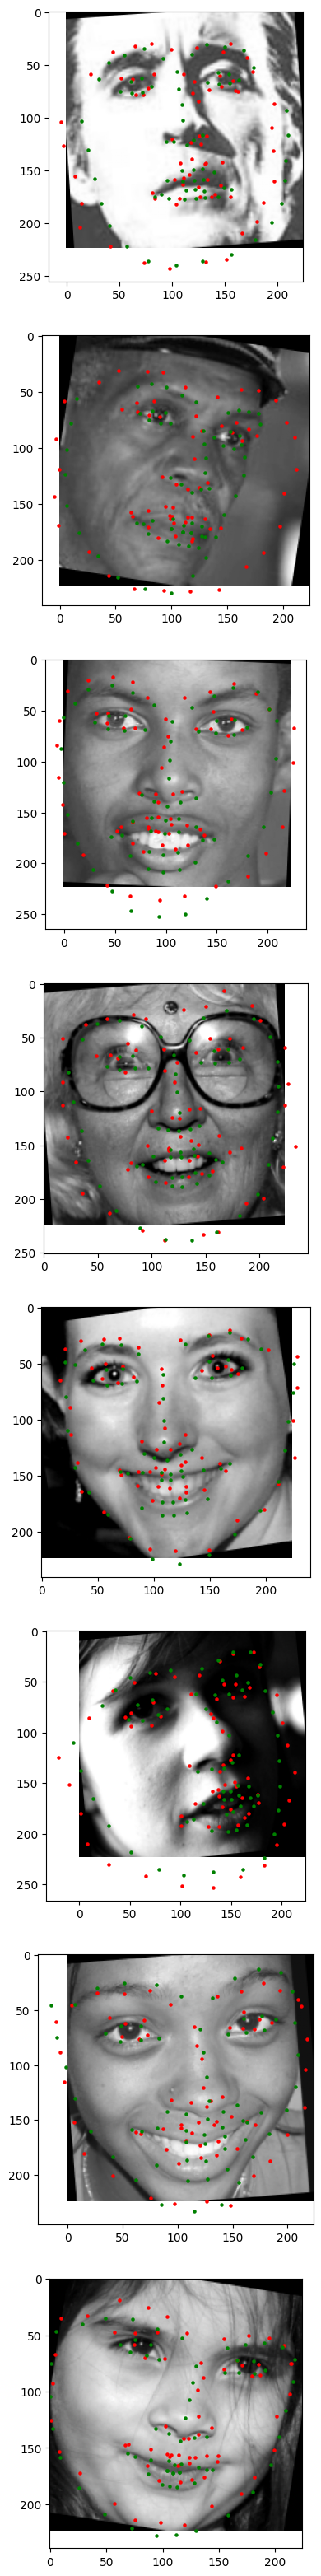

In [12]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/face_landmarks.pth'))
    best_network.eval()

    images, landmarks = next(iter(valid_loader))

    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,68,2)

    plt.figure(figsize=(10,40))

    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time))